In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Mixed Precision 설정 (Apple Silicon에서 성능 향상)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # 반정밀도 설정

# 랜덤 시드 설정 (항상 동일한 변형이 적용되도록)
np.random.seed(12345)
tf.random.set_seed(12345)

In [2]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-09-09 15:53:30.271458: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-09 15:53:30.276415: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-09 15:53:30.276446: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-09 15:53:30.276506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-09 15:53:30.276542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
len(base_model.layers)

154

In [4]:
# 학습할 새로운 레이어 추가 (이진 분류에 맞게 설정)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GlobalAveragePooling2D 사용
x = Dense(128, activation='relu')(x)  # Dense 레이어 추가
x = Dropout(0.5)(x)

# 이진 분류용 출력층 (sigmoid 활성화 함수)
predictions = Dense(1, activation='sigmoid')(x)  # 1개의 유닛, sigmoid 활성화 함수 사용

In [5]:
# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
len(model.layers)

158

In [7]:
# 기본 모델의 가중치는 고정하고, 새로 추가한 레이어만 학습
for layer in base_model.layers[-3:]:  # 마지막 20개의 레이어를 학습 가능하게 변경
    layer.trainable = True

In [8]:
# 모델을 다시 컴파일 (학습률을 낮게 설정하여 미세 조정)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
# 사용자 정의 증강 함수 (이미지 5가지 중 하나를 선택하여 적용)
def custom_augmentation(image):
    augmentation_type = np.random.choice(["rotation", "zoom", "shear", "crop", "horizontal_flip"])
    
    if augmentation_type == "rotation":
        # 회전 각도를 무작위로 선택 (45, 90, 135, ..., 315)
        angles = [45, 90, 135, 180, 225, 270, 315]
        angle = np.random.choice(angles)
        image = tf.keras.preprocessing.image.random_rotation(image, angle)
    
    elif augmentation_type == "zoom":
        # 크기 확대/축소
        image = tf.keras.preprocessing.image.random_zoom(image, (0.8, 1.2), fill_mode='nearest')
    
    elif augmentation_type == "shear":
        # 찌그러뜨리기
        image = tf.keras.preprocessing.image.random_shear(image, 0.2, fill_mode='nearest')
    
    elif augmentation_type == "crop":
        # 이미지 크롭
        image = tf.keras.preprocessing.image.random_shift(image, 0.2, 0.2, fill_mode='nearest')
    
    elif augmentation_type == "horizontal_flip":
        # 좌우 반전
        image = tf.image.flip_left_right(image)
    
    return image

In [10]:
# 원본 데이터를 사용한 ImageDataGenerator (변형 없이 사용)
original_datagen = ImageDataGenerator(rescale=1.0 / 255)  # 정규화만 적용

# 변형된 이미지를 추가하기 위한 ImageDataGenerator
augmented_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=custom_augmentation,  # 사용자 정의 증강 함수 적용
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# 경로에서 데이터를 불러옴
train_data_dir = "./dataset/horse-or-human/train/"
validation_data_dir = "./dataset/horse-or-human/validation/"
img_size = (224, 224)

In [12]:
# 원본 이미지 생성기
original_generator = original_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary'
)

# 변형된 이미지 생성기
augmented_generator = augmented_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary'
)

# 검증 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [13]:
# 두 개의 데이터 제너레이터를 합치는 함수 (원본 1027개 + 변형된 1027개)
def combined_generator(original_gen, augmented_gen):
    while True:
        original_data = next(original_gen)
        augmented_data = next(augmented_gen)
        combined_data = np.concatenate([original_data[0], augmented_data[0]], axis=0)
        combined_labels = np.concatenate([original_data[1], augmented_data[1]], axis=0)
        yield combined_data, combined_labels

In [14]:
# # 데이터셋 로딩 
# train_dir = './dataset/horse-or-human/train/'

# train_datagen = ImageDataGenerator(    
#     rescale=1./255,
#     validation_split=0.2,  # 20%를 검증 데이터로 사용
#     rotation_range=20,     # 이미지 회전
#     width_shift_range=0.2, # 가로 이동
#     height_shift_range=0.2,# 세로 이동
#     shear_range=0.2,       # 이미지 기울이기
#     zoom_range=0.2,        # 이미지 확대/축소
#     horizontal_flip=True   # 좌우 반전
# )
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='training'
# )
# validation_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'
# )

In [15]:
# 조기 종료 콜백 설정
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 체크포인트 콜백 설정 (가장 좋은 가중치를 저장)
checkpoint = ModelCheckpoint(
    'best_model.keras',   # 저장할 파일 이름
    monitor='val_loss',  # 검증 데이터의 손실을 모니터링
    save_best_only=True,  # 가장 좋은 성능일 때만 저장
    save_weights_only=False,  # 모델 전체를 저장
    verbose=1  # 저장될 때마다 메시지를 출력
)

# 학습률 감소 콜백 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # 검증 데이터 손실 모니터링
    factor=0.2,           # 학습률을 20%로 감소
    patience=2,           # 2 에포크 동안 성능 개선이 없을 시 학습률 감소
    min_lr=1e-6           # 학습률의 최솟값
)

combined_train = combined_generator(original_generator, augmented_generator)

# 모델 학습
history = model.fit(
    combined_train,
    epochs=10,
    steps_per_epoch=len(original_generator),  # 배치 크기에 맞춘 steps_per_epoch
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint,reduce_lr]  # 조기 종료 콜백 추가
    # early_stopping,
)

Epoch 1/10


2024-09-09 15:53:41.381215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5555 - loss: 0.7593

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.33741, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 366s 9s/step - accuracy: 0.5579 - loss: 0.7561 - val_accuracy: 0.9727 - val_loss: 0.3374 - learning_rate: 1.0000e-05
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8508 - loss: 0.3725 

2024-09-09 16:05:14.130034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-09 16:05:14.130450: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1760482142531741294
2024-09-09 16:05:14.132136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 334s 10s/step - accuracy: 0.8513 - loss: 0.3718 - learning_rate: 1.0000e-05
Epoch 3/10


/opt/anaconda3/envs/tf/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9218 - loss: 0.2609
Epoch 3: val_loss improved from 0.33741 to 0.09797, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 304s 9s/step - accuracy: 0.9221 - loss: 0.2601 - val_accuracy: 0.9844 - val_loss: 0.0980 - learning_rate: 1.0000e-05
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9617 - loss: 0.1637

2024-09-09 16:15:01.407402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-09 16:15:01.407810: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1760482142531741294
2024-09-09 16:15:01.408629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 284s 8s/step - accuracy: 0.9617 - loss: 0.1635 - learning_rate: 1.0000e-05
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9614 - loss: 0.1348 
Epoch 5: val_loss improved from 0.09797 to 0.05095, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 411s 12s/step - accuracy: 0.9616 - loss: 0.1344 - val_accuracy: 0.9922 - val_loss: 0.0509 - learning_rate: 1.0000e-05
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9689 - loss: 0.1061 

2024-09-09 16:29:36.732279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-09 16:29:36.732618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1760482142531741294
2024-09-09 16:29:36.735826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 465s 14s/step - accuracy: 0.9688 - loss: 0.1060 - learning_rate: 1.0000e-05
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9629 - loss: 0.1049 
Epoch 7: val_loss improved from 0.05095 to 0.03290, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 690s 21s/step - accuracy: 0.9630 - loss: 0.1047 - val_accuracy: 0.9922 - val_loss: 0.0329 - learning_rate: 1.0000e-05
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9652 - loss: 0.0864 

2024-09-09 16:50:13.172484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-09 16:50:13.174673: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1760482142531741294
2024-09-09 16:50:13.183006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 546s 16s/step - accuracy: 0.9654 - loss: 0.0861 - learning_rate: 1.0000e-05
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9758 - loss: 0.0741 
Epoch 9: val_loss improved from 0.03290 to 0.02809, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 432s 13s/step - accuracy: 0.9760 - loss: 0.0739 - val_accuracy: 0.9922 - val_loss: 0.0281 - learning_rate: 1.0000e-05
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9836 - loss: 0.0585

2024-09-09 17:02:32.500340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-09 17:02:32.500815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1760482142531741294
2024-09-09 17:02:32.502375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 308s 9s/step - accuracy: 0.9835 - loss: 0.0588 - learning_rate: 1.0000e-05


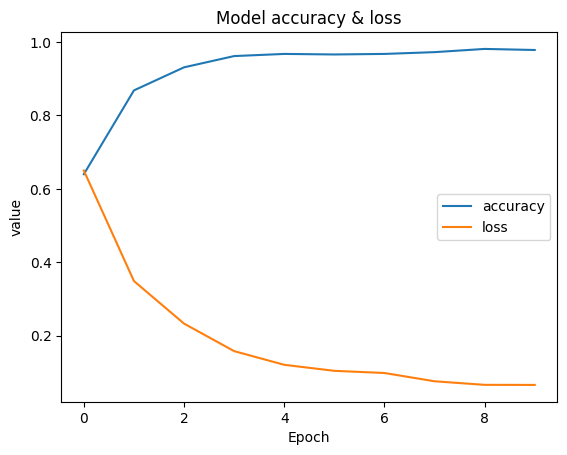

In [16]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

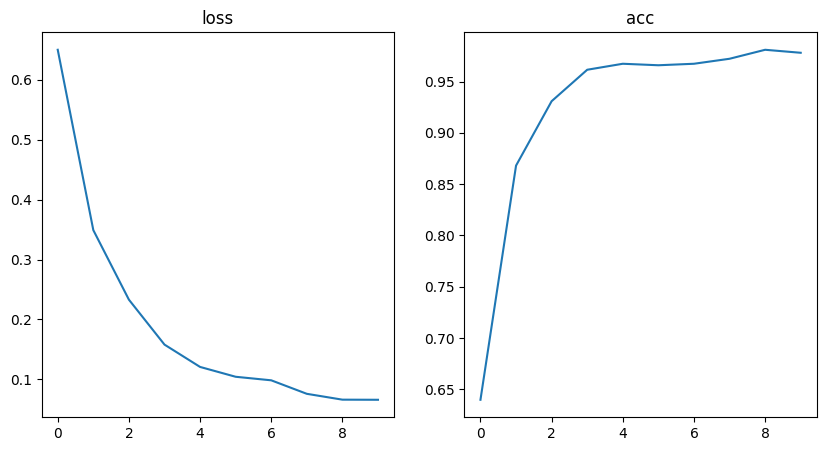

In [17]:
#loss, acc 현황을 그래프로 확인
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("acc")
plt.plot(history.history['accuracy'])
plt.show()

In [18]:
# 모델 검증
results = model.evaluate(validation_generator)
print("test loss, test acc:", results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.9965 - loss: 0.0217
test loss, test acc: [0.027635222300887108, 0.9921875]


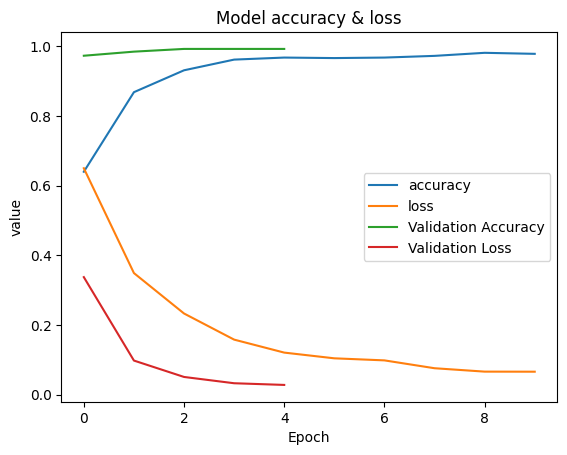

In [31]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.show()

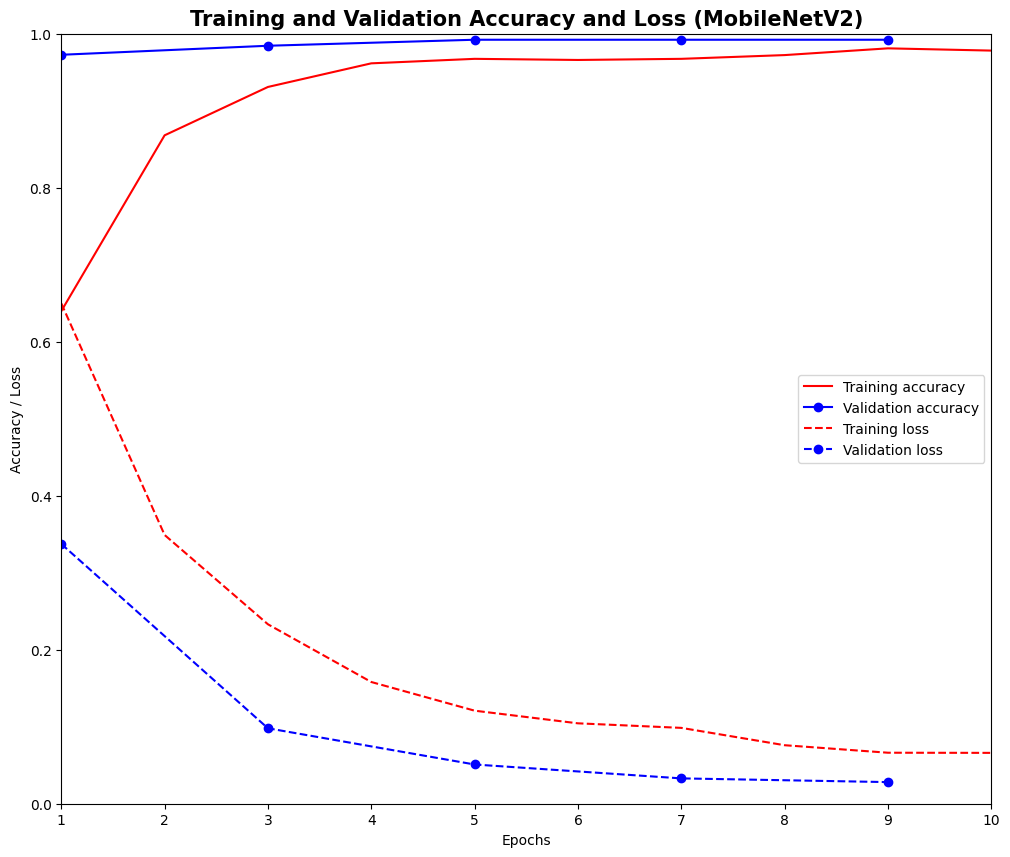

In [46]:
# 학습 결과 시각화
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

num_epochs = 10
# 에포크 범위 설정
plt.figure(figsize=(12,10))
epochs = range(1, num_epochs + 1)  # x축을 1부터 num_epochs까지 설정
# 정확도 시각화
plt.plot(epochs, acc[:num_epochs], "r", label="Training accuracy")
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_acc,  # y축: 검증 정확도
    "b",
    label="Validation accuracy",
    marker='o'
)
# 손실 시각화
plt.plot(epochs, loss[:num_epochs], "r--", label="Training loss")
# Validation loss: 홀수 에포크에서만 표시
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_loss,  # y축: 검증 손실
    "b--",
    label="Validation loss",
    marker='o'
)
# 그래프 제목 및 레이블 설정
plt.title("Training and Validation Accuracy and Loss (MobileNetV2)", fontsize='15', fontweight='bold')
plt.xlabel("Epochs", fontsize='10')
plt.ylabel("Accuracy / Loss", fontsize='10')
plt.legend()
# x축 범위 설정
plt.xlim(1, num_epochs)  # x축 범위를 1에서 num_epochs까지 설정
plt.ylim(0,1)
# 그래프 표시
plt.show()

In [40]:
print(history.history["val_accuracy"])  # 모든 에포크에 대한 val_acc가 있는지 확인
print(history.history["val_loss"])  # 모든 에포크에 대한 val_loss가 있는지 확인

[0.97265625, 0.984375, 0.9921875, 0.9921875, 0.9921875]
[0.3374063968658447, 0.09797492623329163, 0.05094575136899948, 0.03290148824453354, 0.028087031096220016]


In [47]:
import os
import cv2
import numpy as np
# 이미지 경로 설정
dlist = './dataset/horse-or-human/test/'
predict_list = [f for f in os.listdir(dlist) if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp'))]  # 이미지 파일만 선택

# 실제 레이블 설정 (파일 이름에 따라 설정)
true_labels = []
for file_name in predict_list:
    if "human" in file_name or "사람" in file_name:  # 사람을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(1)
    elif "horse" in file_name or "말" in file_name:  # 말을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(0)
        
print(len(true_labels),len(predict_list))

# 실제 레이블과 예측할 이미지 개수가 일치하는지 확인
assert len(true_labels) == len(predict_list), "레이블과 이미지 파일 개수가 일치하지 않습니다."

# 이미지 전처리
img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (224, 224)) for i in img]  # 모델 입력 크기에 맞게 이미지 크기 조정
img = np.array(img)
img = img.astype('float32') / 255.0  # 정규화

# 분류
cutoff = 0.5
predictions = model.predict(img)

# 예측 결과 출력 및 맞춘 비율 계산
correct_count = 0
total_count = len(predictions)

for idx, prediction in enumerate(predictions):
    file_name = predict_list[idx]
    confidence = float(prediction[0])  # 예측 확률 (맞춤 비율)
    predicted_label = 1 if confidence >= cutoff else 0  # cutoff에 따른 예측 레이블
    
    # 실제 레이블과 예측 레이블을 비교
    if predicted_label == true_labels[idx]:
        correct_count += 1  # 맞춘 경우 카운트 증가
    
    # 파일 이름과 확률 출력
    if predicted_label == 1:
        print(f"{file_name}: 사람, 확률: {confidence:.2f}")
    else:
        print(f"{file_name}: 말, 확률: {1 - confidence:.2f}")

# 전체 맞춘 비율 (정확도) 계산
accuracy = correct_count / total_count
print(f"\n전체 맞춘 비율(정확도): {accuracy * 100:.2f}%")

235 235
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step 
human_081.jpeg: 사람, 확률: 0.79
human_51.jpg: 사람, 확률: 0.75
human_023.jpg: 사람, 확률: 0.78
human_28.jpeg: 사람, 확률: 0.97
horse_077.jpeg: 말, 확률: 0.98
horse_098.jpeg: 말, 확률: 0.99
horse_001.jpg: 말, 확률: 0.95
human_078.jpeg: 사람, 확률: 0.77
human_097.jpeg: 사람, 확률: 0.56
human_45.jpeg: 사람, 확률: 0.89
horse_014.jpg: 사람, 확률: 0.96
horse_26.jpeg: 말, 확률: 0.99
human_022.jpg: 사람, 확률: 0.90
human_008.jpg: 사람, 확률: 0.90
human_020.jpg: 사람, 확률: 0.85
human_52.jpg: 사람, 확률: 0.69
human_73.jpeg: 말, 확률: 0.77
horse_094.jpeg: 말, 확률: 0.97
horse_082.jpeg: 말, 확률: 0.85
horse_002.jpg: 말, 확률: 0.56
human_32.jpeg: 사람, 확률: 0.87
horse_15.webp: 말, 확률: 1.00
human_49.jpeg: 사람, 확률: 0.97
horse_003.jpg: 말, 확률: 0.95
horse_017.jpg: 말, 확률: 0.79
horse_016.jpeg: 말, 확률: 0.98
human_53.jpg: 사람, 확률: 0.83
human_021.jpg: 사람, 확률: 0.94
human_009.jpg: 사람, 확률: 0.67
horse_057.jpeg: 말, 확률: 0.64
human_025.jpg: 사람, 확률: 0.96
human_019.jpg: 사람, 확률: 0.93
horse_013.jpg: 말, 확률: 0.95
horse_007.jpg: 말, 확률: 0.98
human_48.jp

In [48]:
model.save('MobileNetV2_binary_modify.keras')